In [807]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
%matplotlib inline

In [885]:
train = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")

In [886]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [887]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [929]:
train.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

## Clean the Data

In [889]:
print train[train['Survived']==1]["Age"].mean(), \
train[train['Survived']==0]["Age"].mean(), \
test.Age.mean()

28.3436896552 30.6261792453 30.2725903614


In [890]:
def clean_data(titanic):
# def clean_data(titanic, traindata=True):
    

#     titanic.loc[(titanic["Sex"] == "female") , "Age"] = \
#         titanic.loc[(titanic["Sex"] == "female") , "Age"].fillna(28.34)
#     titanic.loc[(titanic["Sex"] == "male") , "Age"] = \
#         titanic.loc[(titanic["Sex"] == "male") , "Age"].fillna(30.62)
#         (titanic[titanic['Survived']==0]["Age"].mean())

    titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())

    titanic = titanic.copy()
    
    titanic.Age = titanic.Age/titanic.Age.max()
    titanic.Fare = titanic.Fare/titanic.Fare.max()
    
    titanic.loc[titanic["Sex"] == "male", "Sex"] = -10
    titanic.loc[titanic["Sex"] == "female", "Sex"] = 10
    
    titanic['AgeSex'] = titanic.Age * titanic.Sex
    titanic['AgeSexFare'] = titanic.Age * titanic.Sex * titanic.Fare
#     titanic['PclassSq'] = titanic.Pclass ** 2
#     titanic['SexFare'] = titanic.Sex * titanic.Fare
    titanic["FamilySize"] = titanic['Parch'] + titanic['SibSp']

    titanic["Embarked"] = titanic["Embarked"].fillna("S")
    titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 1
    titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 2
    titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 3

    titanic.drop(titanic[['Name', 'Ticket', 'Cabin']], axis = 1, inplace=True)

    return titanic

In [891]:
# train = train[train.Age > 0]
# train.info()

In [892]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [893]:
df = clean_data(train)
df_train = clean_data(train)
df_train.drop('PassengerId', axis=1, inplace=True)
df_test  = clean_data(test)

In [894]:
y = df_train.pop('Survived').values
X = df_train.values
X_test = df_test.values

## Exploring the Data

In [895]:
df_train.describe()

,Pclass,Age,SibSp,Parch,Fare,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.371830,0.523008,0.381594,0.062858,0.904602
std,0.836071,0.162634,1.102743,0.806057,0.096995,1.613459
min,1.000000,0.005250,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.275000,0.000000,0.000000,0.015440,0.000000
50%,3.000000,0.375000,0.000000,0.000000,0.028213,0.000000
75%,3.000000,0.437500,1.000000,0.000000,0.060508,1.000000
max,3.000000,1.000000,8.000000,6.000000,1.000000,10.000000


In [896]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass        891 non-null int64
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
AgeSex        891 non-null object
AgeSexFare    891 non-null object
FamilySize    891 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


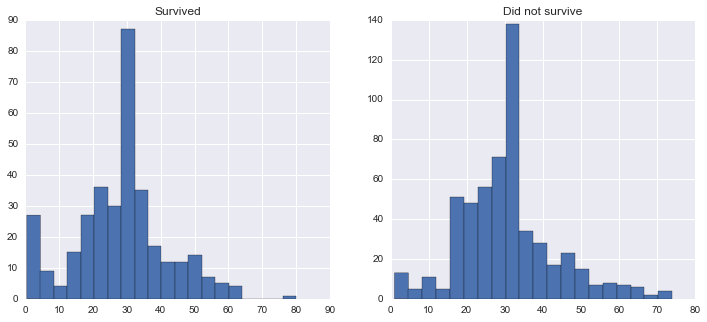

In [897]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
train[train['Survived']==1]["Age"].hist(bins=20, label='survived')
plt.title('Survived')
plt.subplot(1,2,2)
train[train['Survived']==0]["Age"].hist(bins=20)
plt.title('Did not survive')

In [898]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
AgeSex         418 non-null object
AgeSexFare     418 non-null object
FamilySize     418 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 39.2+ KB


In [899]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891,446.000000,257.353842,1.00000,223.50000,446.000000,668.500000,891
Survived,891,0.383838,0.486592,0.00000,0.00000,0.000000,1.000000,1
Pclass,891,2.308642,0.836071,1.00000,2.00000,3.000000,3.000000,3
Age,891,0.371830,0.162634,0.00525,0.27500,0.375000,0.437500,1
SibSp,891,0.523008,1.102743,0.00000,0.00000,0.000000,1.000000,8
Parch,891,0.381594,0.806057,0.00000,0.00000,0.000000,0.000000,6
Fare,891,0.062858,0.096995,0.00000,0.01544,0.028213,0.060508,1
FamilySize,891,0.904602,1.613459,0.00000,0.00000,0.000000,1.000000,10


In [900]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeSex,AgeSexFare,FamilySize
0,1,0,3,-10,0.2750,1,0,0.014151,1,-2.75,-0.0389154,1
1,2,1,1,10,0.4750,1,0,0.139136,2,4.75,0.660895,1
2,3,1,3,10,0.3250,0,0,0.015469,1,3.25,0.0502729,0
3,4,1,1,10,0.4375,1,0,0.103644,1,4.375,0.453444,1
4,5,0,3,-10,0.4375,0,0,0.015713,1,-4.375,-0.0687424,0


## Random Forest

In [901]:
rf = RandomForestClassifier(60)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [902]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([8, 7, 5, 2, 0, 1, 9, 3, 6, 4])

In [903]:
df_train.columns[feat_rank]

Index([u'AgeSexFare', u'AgeSex', u'Fare', u'Age', u'Pclass', u'Sex',
       u'FamilySize', u'SibSp', u'Embarked', u'Parch'],
      dtype='object')

In [904]:
df_features = pd.DataFrame(rf.feature_importances_,df_train.columns, columns = ['feature_value'])

In [905]:
df_features.sort_values('feature_value', ascending=False)

,feature_value
AgeSexFare,0.256327
AgeSex,0.222184
Fare,0.152783
Age,0.103003
Pclass,0.072134
Sex,0.071092
FamilySize,0.053158
SibSp,0.026772
Embarked,0.024599
Parch,0.017947


In [916]:
features = [df_train.columns[feat_rank][x] for x in range(7)]
features

['AgeSexFare', 'AgeSex', 'Fare', 'Age', 'Pclass', 'Sex', 'FamilySize']

In [917]:
# def crossValidate(features, target, classifier, k_fold, r_state=None):

#     k_fold_indices = KFold(len(features), n_folds=k_fold, shuffle=True, random_state=r_state)
    
#     k_score_total = 0
#     for train_indices, test_indices in k_fold_indices :
#         model = classifier.fit(features[train_indices], target[train_indices])
#         k_score = model.score(features[test_indices], target[test_indices])
#         k_score_total = k_score_total + k_score
#     return k_score_total/k_fold

In [918]:
# results = []
# for x in range (10,50,10):
#     for i in range(2,6):
#         for j in range(2,6):
#             results.append((crossValidate(X, y, RandomForestClassifier(x, min_samples_split=i, 
#                                                                        min_samples_leaf=j), 10, 0), x, i, j))

# max(results)

In [919]:
# sorted(results, reverse=True)[:5]

In [921]:
model = RandomForestClassifier(
#     random_state=1,
      n_estimators=40, 
#     min_samples_split=4,
#     min_samples_leaf=2
)

scores = cross_val_score(model, df[features], df['Survived'], cv=5)

print 'mean:', (scores.mean())

mean: 0.819394301768


Feature ranking:
1. feature 7 (0.228790)
2. feature 8 (0.220813)
3. feature 5 (0.146609)
4. feature 1 (0.113066)
5. feature 2 (0.101528)
6. feature 0 (0.071373)
7. feature 9 (0.039935)
8. feature 3 (0.035664)
9. feature 6 (0.022164)
10. feature 4 (0.020058)


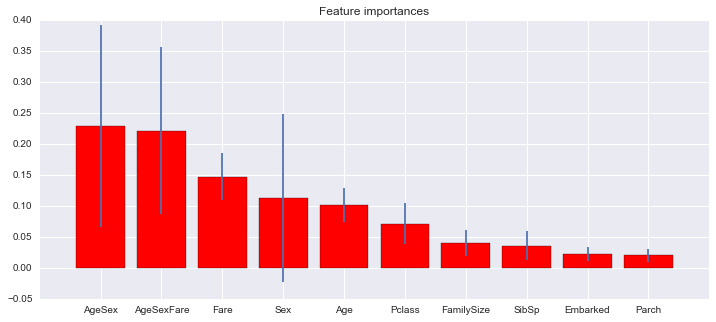

In [922]:
model.fit(X, y)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), df_train.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

In [923]:
features = [df_train.columns[indices][x] for x in range(7)]
features

['AgeSex', 'AgeSexFare', 'Fare', 'Sex', 'Age', 'Pclass', 'FamilySize']

In [924]:
X = df_train[features].values
X

array([[-2.75, -0.03891540829607214, 0.014151057562208049, ..., 0.275, 3, 1],
       [4.75, 0.6608947430675433, 0.13913573538264068, ..., 0.475, 1, 1],
       [3.25, 0.05027285190849946, 0.015468569817999833, ..., 0.325, 3, 0],
       ..., 
       [3.5425, 0.16214501340153947, 0.04577135170121086, ..., 0.35425, 3,
        3],
       [-3.25, -0.190307325836591, 0.05855610025741261, ..., 0.325, 1, 0],
       [-4.0, -0.060507970265993034, 0.015126992566498259, ..., 0.4, 3, 0]], dtype=object)

In [925]:
# rf_param_grid = {'max_depth': [3, None],
#                 'max_features': ['sqrt', 'log2', None],
#                 'min_samples_split': [1, 2, 4],
#                 'min_samples_leaf': [1, 2, 4],
#                 'bootstrap': [True, False],
#                 'n_estimators': [10, 20, 40],
#                 'random_state': [1]}

# rf_gridsearch = GridSearchCV(RandomForestClassifier(),
#                RandomForestClassifierssifierssifierssifier rf_param_grid,
#                              n_jobs=-1,
#                              verbose=True,
#                              scoring='accuracy')
# rf_gridsearch.fit(X, y)

# print "best parameters:", rf_gridsearch.best_params_

# best_rf_model = rf_gridsearch.best_estimator_

In [926]:
def create_submission(model, train, test, features, filename):

    model.fit(train[features], train['Survived'])
    predictions = model.predict(test[features])

    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [927]:
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier()


# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 6),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              'n_estimators': [10, 20, 40, 60],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

# use a full grid over all parameters
param_grid = {'max_depth': [3, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_split': [1, 2, 4],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False],
              'n_estimators': [10, 20, 40, 60],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

RandomizedSearchCV took 10.13 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.837 (std: 0.023)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 10, 'criterion': 'gini', 'max_features': 5, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.833 (std: 0.019)
Parameters: {'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 60, 'min_samples_split': 5, 'criterion': 'gini', 'max_features': 5, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.832 (std: 0.023)
Parameters: {'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 10, 'min_samples_split': 9, 'criterion': 'entropy', 'max_features': 5, 'max_depth': None}

GridSearchCV took 193.78 seconds for 864 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.838 (std: 0.026)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 60, 'min_samples_split': 4, 'criterion': 'gini', 'max_fea

In [928]:
create_submission(RandomForestClassifier(
                        bootstrap= True, 
                        min_samples_leaf= 4, 
                        n_estimators= 60, 
                        min_samples_split= 4, 
                        criterion= 'gini', 
                        max_features= None, 
                        max_depth= None), \
                        df, df_test, features, "rf_submission.csv")

Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 60, 'min_samples_split': 4, 'criterion': 'gini', 'max_features': None, 'max_depth': None}

{'bootstrap': True, 'min_samples_leaf': 3, 
 'n_estimators': 20, 'min_samples_split': 9, 'criterion': 'entropy', 
 'max_features': 4, 'max_depth': None}

## Random Forest Results

```
0.79426
['AgeSex', 'AgeSexFare', 'Fare', 'Sex', 'Pclass', 'Age']
create_submission(RandomForestClassifier(
                        bootstrap= True, 
                        min_samples_leaf= 3, 
                        n_estimators= 20, 
                        min_samples_split= 9, 
                        criterion= 'entropy', 
                        max_features= 4, 
                        max_depth= None)

0.78469
['AgeSex', 'AgeSexFare', 'Fare', 'Age', 'Pclass', 'Sex']
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, predictors, "submission.csv")
0.76555
['AgeSex', 'AgeSexFare', 'Fare', 'Age']
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, features, "submission.csv")
```

In [ ]:
trees_accuracy = []
for i in xrange(1,X.shape[1]):
    rf = RandomForestClassifier(50, max_features = i, min_samples_split=4, min_samples_leaf=2)
    rf.fit(X, y)
    trees_accuracy.append(rf.score(X,y))

In [ ]:
plt.plot(range(1, X.shape[1]), trees_accuracy, '-o')

## SVM

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(kernel='linear'))])
pipeline.fit(X, y)

In [ ]:
parameters = {'kernel':['linear','rbf'], 
              'C':np.linspace(.001,10,5),'degree':np.linspace(0,10,5)}

gsCV = GridSearchCV(estimator=pipeline.steps[1][1],
                    param_grid=parameters,scoring='accuracy', cv=5)

In [ ]:
X = pipeline.steps[0][1].fit_transform(X)

In [ ]:
gsCV.fit(X,y)

In [ ]:
gsCV.grid_scores_, gsCV.best_params_

mean: 0.78151, std: 0.03323, params: {'C': 25.00075, 'degree': 0.0}

In [ ]:
def svm_submission(model, train, test, features, filename):

    model.fit(train[features], train['Survived'])
    predictions = model.predict(test[features])

    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [ ]:
svm_features = [df_train.columns[feat_rank][x] for x in range(8)]
svm_features

In [ ]:
create_submission(Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC(kernel='rbf', C=2.5, degree=2.5))]), \
                  df, df_test, svm_features, "svm_submission.csv")

## Gradient Boosting

In [191]:
X = df_train
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeSex,AgeSexFare,FamilySize
0,3,-1,0.2750,1,0,0.014151,1,-0.275,-0.00389154,1
1,1,1,0.4750,1,0,0.139136,2,0.475,0.0660895,1
2,3,1,0.3250,0,0,0.015469,1,0.325,0.00502729,0
3,1,1,0.4375,1,0,0.103644,1,0.4375,0.0453444,1
4,3,-1,0.4375,0,0,0.015713,1,-0.4375,-0.00687424,0


In [192]:
gdb = GradientBoostingClassifier(
                n_estimators=3000,
                learning_rate = 0.01, 
                max_depth = 4,
                max_features = 0.1,
                min_samples_leaf = 17)
gdb.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=4, max_features=0.1, max_leaf_nodes=None,
              min_samples_leaf=17, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [193]:
feat_rank = np.argsort(gdb.feature_importances_)[::-1]
feat_rank
df_train.columns[feat_rank]

Index([u'AgeSexFare', u'Fare', u'AgeSex', u'Age', u'FamilySize', u'Pclass',
       u'SibSp', u'Sex', u'Embarked', u'Parch'],
      dtype='object')

In [194]:
boost_features = [df_train.columns[feat_rank][x] for x in range(6)]
boost_features

['AgeSexFare', 'Fare', 'AgeSex', 'Age', 'FamilySize', 'Pclass']

In [195]:
df_train[boost_features].head()

,AgeSexFare,Fare,AgeSex,Age,FamilySize,Pclass
0,-0.00389154,0.014151,-0.275,0.2750,1,3
1,0.0660895,0.139136,0.475,0.4750,1,1
2,0.00502729,0.015469,0.325,0.3250,0,3
3,0.0453444,0.103644,0.4375,0.4375,1,1
4,-0.00687424,0.015713,-0.4375,0.4375,0,3


In [196]:
X = df_train[boost_features]
X.head()

,AgeSexFare,Fare,AgeSex,Age,FamilySize,Pclass
0,-0.00389154,0.014151,-0.275,0.2750,1,3
1,0.0660895,0.139136,0.475,0.4750,1,1
2,0.00502729,0.015469,0.325,0.3250,0,3
3,0.0453444,0.103644,0.4375,0.4375,1,1
4,-0.00687424,0.015713,-0.4375,0.4375,0,3


In [190]:
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]}
gdb_grid = GradientBoostingClassifier(n_estimators=6000)
gs_cv = GridSearchCV(gdb_grid, param_grid).fit(X,y)

gs_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 0.1,
 'min_samples_leaf': 9}

```
BEST PARAMS
{'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 0.1,
 'min_samples_leaf': 17}
 ```

In [197]:
create_submission(GradientBoostingClassifier(
                n_estimators=3000,
                learning_rate = 0.01, 
                max_depth = 4,
                max_features = 0.1,
                min_samples_leaf = 9),
                df, df_test, boost_features, "gdboost_submission.csv")

## Adaptive Boosting

In [204]:
X = df_train
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeSex,AgeSexFare,FamilySize
0,3,-1,0.2750,1,0,0.014151,1,-0.275,-0.00389154,1
1,1,1,0.4750,1,0,0.139136,2,0.475,0.0660895,1
2,3,1,0.3250,0,0,0.015469,1,0.325,0.00502729,0
3,1,1,0.4375,1,0,0.103644,1,0.4375,0.0453444,1
4,3,-1,0.4375,0,0,0.015713,1,-0.4375,-0.00687424,0


In [205]:
ada = AdaBoostClassifier(
                n_estimators=3000,
                learning_rate = 0.01)
ada.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=3000, random_state=None)

In [211]:
feat_rank = np.argsort(ada.feature_importances_)[::-1]
ada_features = [df_train.columns[feat_rank][x] for x in range(6)]
ada_features

['Fare', 'AgeSexFare', 'AgeSex', 'Age', 'FamilySize', 'Pclass']

In [212]:
X = df_train[ada_features]
X.head()

,Fare,AgeSexFare,AgeSex,Age,FamilySize,Pclass
0,0.014151,-0.00389154,-0.275,0.2750,1,3
1,0.139136,0.0660895,0.475,0.4750,1,1
2,0.015469,0.00502729,0.325,0.3250,0,3
3,0.103644,0.0453444,0.4375,0.4375,1,1
4,0.015713,-0.00687424,-0.4375,0.4375,0,3


In [201]:
param_grid = {'learning_rate': [1, 0.1, 0.05, 0.02, 0.01]}

ada_grid = AdaBoostClassifier(n_estimators=6000)
ada_cv = GridSearchCV(ada_grid, param_grid).fit(X,y)

ada_cv.best_params_

{'learning_rate': 0.1}

In [213]:
create_submission(AdaBoostClassifier(
                n_estimators=3000,
                learning_rate = 0.01),
                df, df_test, ada_features, "adaboost_submission.csv")